# Predicting The Amount Of Aces a Player Will Get In a Tennis Match

## Introduction:
Our dataset contains the results, statistics and rankings for tennis tournaments in 2017-2019. The dataset we’re using is sourced from github and contains 50 columns and 6866 rows of data. We will be predicting the number of aces that player will obtain in a given match. We will examine whether the amount of aces a player scores is independent of their opponent, or if it depends on the match up. We will analyze each player's historical amount of aces and rank points. We will graph the amount of aces for each player vs their hisorical amount and the amount minus the historical amount vs the player's rank points and the difference in rank points between the players to determine if the amount changes depending on how good the opponent is. An ace refers to a point scored by a player directly from a serve. We will use ATP match data from 2017 and 2018 as the data, with 3/4 of it being training data.

## Methods: 
We will examine whether the amount of aces a player scores is independent of their opponent, or if it depends on the match up. We will analyze each player's historical amount of aces and rank points. We can calculate historical averages using the cummean function. After we have calculated the new columns, we must tidy the data so that only one player is in each row. There are currently both a winner and loser in one row, which makes analysis very complicated unless it is tidied first. We will graph the amount of aces for each player vs their hisorical amount and the amount minus the historical amount vs the player's rank points and the difference in rank points between the players to determine if the amount changes depending on how good the opponent is. An ace refers to a point scored by a player directly from a serve. We will use ATP match data from 2017 and 2018 as the data, with 3/4 of it being training data. We will then use kknn regression analysis to create a model that can predict new values. 

## Expected Outcome and Significance: 
I expect If the RMSE on the model is low on the test set, we have a succesful model, and we can predict the amount of aces a player will get in a given match. If it does not work, it is likely that the rank points or rank difference do not actually affect the amount of aces a player might have in a game. I expect that the model will work. Being able to predict the number of aces a player will get probably won't impact how tennis is analyzed or played, but being able to answer this question is a step toward predicting who will win a tennis game. We could do that by doing a similar knn analysis, but it is likely much more difficult.

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
matches_2017 <- read_csv(url('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv'))
matches_2018 <- read_csv(url('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv'))
matches_17_18 <- rbind(matches_2017, matches_2018)

Rows: 2911 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2897 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
pre_ace_data <- matches_17_18 |>
    select(tourney_id, tourney_date, match_num, winner_id, w_ace, winner_rank_points, loser_id, l_ace, loser_rank_points)
ace_data <- pre_ace_data |>
    mutate(w_rank_diff = winner_rank_points - loser_rank_points) |>
    mutate(l_rank_diff = loser_rank_points - winner_rank_points) |>
    pivot_longer(
        cols = c(winner_id, loser_id),
        names_to = "win",
        values_to = "player_id") |>
    pivot_longer(
        cols = c(winner_rank_points, loser_rank_points),
        names_to = "win2",
        values_to = "rank_points") |>
    pivot_longer(
        cols = c(w_rank_diff, l_rank_diff),
        names_to = "win3",
        values_to = "rank_diff") |>
    pivot_longer(
        cols = c(w_ace, l_ace),
        names_to = "win4",
        values_to = "ace") |>
    mutate_at(c('win', 'win2', 'win3', 'win4'), as.factor) |>
    mutate_at(c('win', 'win2', 'win3', 'win4'), as.numeric) |>
    filter(win == win2 & win2 == win3 & win3 == win4) |>
    select(-win, -win2, -win3, -win4) |>
    arrange(tourney_date, player_id) |>
    group_by(player_id) |>
    na.omit() |>
    mutate(ace_avg = lag(cummean(ifelse(is.na(ace), 0, ace)))) |>
    ungroup() |>
    mutate(ace_diff = ace - ace_avg)
ace_data


tourney_id,tourney_date,match_num,player_id,rank_points,rank_diff,ace,ace_avg,ace_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-0451,20170102,273,103285,558,-582,2,NA,NA
2017-0451,20170102,287,103285,558,102,0,2,-2
2017-0451,20170102,294,103285,558,-11222,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,4,105227,4250,3005,7,10.899225,-3.8992248
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,4,106298,1245,-3005,10,8.766990,1.2330097
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,1,106432,2480,1430,5,5.899083,-0.8990826


We had to replace missing values with 0 because we could not find a way to make cummean ignore NA values.

Warning message:
“Removed 72 rows containing missing values (geom_point).”


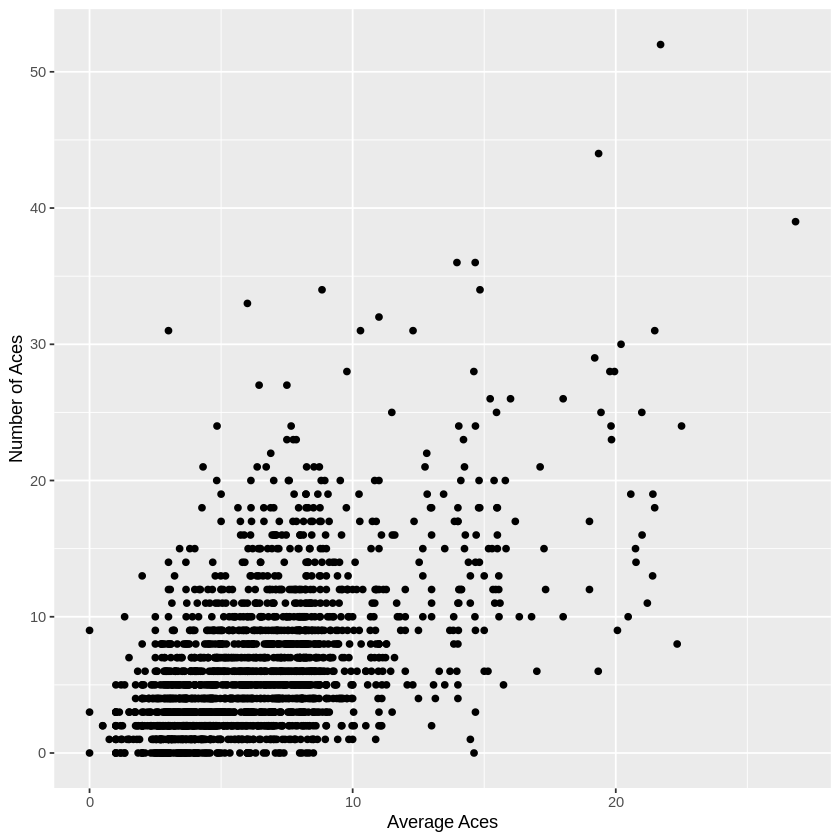

In [38]:
sample_data <- ace_data |>
    sample_n(2000)
aces_vs_average <- sample_data |>
    ggplot(aes(x = ace_avg, y = ace)) +
    geom_point() +
    labs(x = 'Average Aces', y = 'Number of Aces')
aces_vs_average

The graph has a weak postive linear correlation, so average number of aces is a good predictor of aces in a match.

Warning message:
“Removed 72 rows containing missing values (geom_point).”
Warning message:
“Removed 72 rows containing missing values (geom_point).”


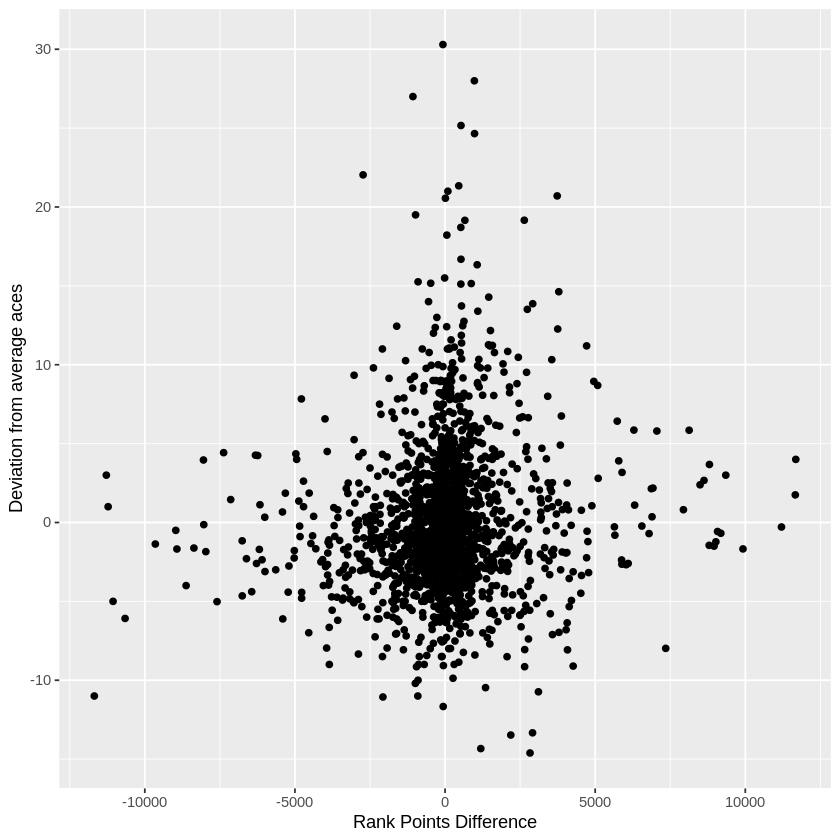

tourney_id,tourney_date,match_num,player_id,rank_points,rank_diff,ace,ace_avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-0451,20170102,273,103285,558,-582,2,NA
2017-0451,20170102,287,103285,558,102,0,2
2017-0451,20170102,294,103285,558,-11222,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,4,105227,4250,3005,7,10.899225
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,4,106298,1245,-3005,10,8.766990
2018-M-DC-2018-WG-M-FRA-CRO-01,20181123,1,106432,2480,1430,5,5.899083


mean(ace)
<dbl>
6.56745


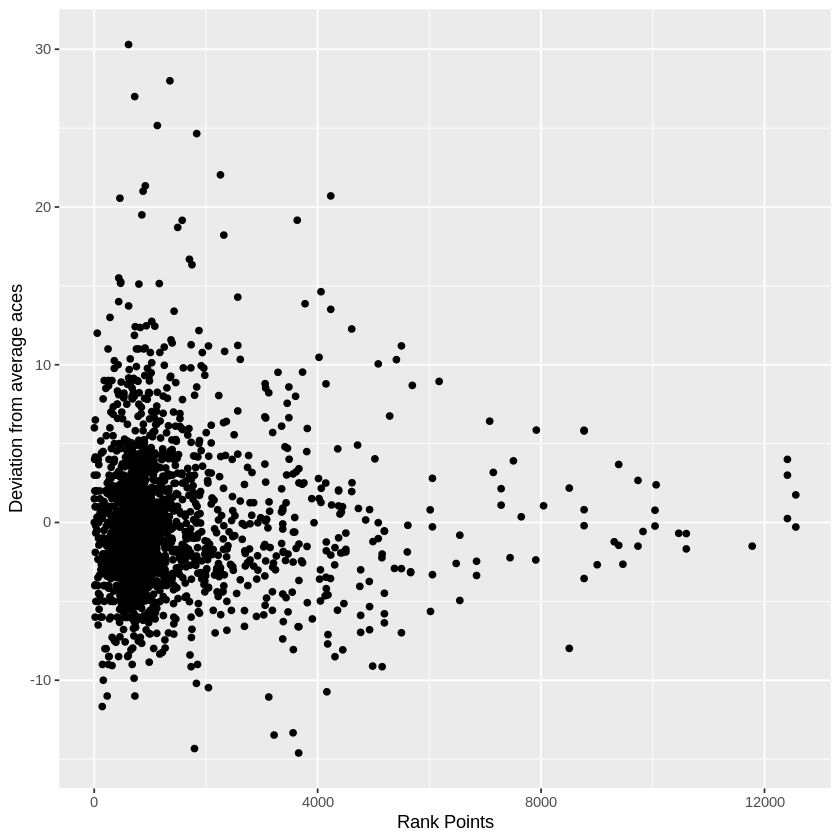

In [43]:
ace_diff_vs_rank_diff <- sample_data |>
    ggplot(aes(x = rank_diff, y = ace_diff)) +
    geom_point() +
    labs(x = 'Rank Points Difference', y = 'Deviation from average aces')
ace_diff_vs_rank_diff
ace_diff_vs_rank <- sample_data |>
    ggplot(aes(x = rank_points, y = ace_diff)) +
    geom_point() +
    labs(x = 'Rank Points', y = 'Deviation from average aces')
ace_diff_vs_rank
ace_data2 <- ace_data |>
    select(-ace_diff)
ace_data2
ace_data3 <- na.omit(ace_data2)
ace_avg_summary <- ace_data3 |>
    summarize(mean(ace))
ace_avg_summary

It is hard to tell from the graphs whether rank or the difference in rank between players will contribute to the number of aces in the match. We will still include rank points in the regression analysis because it is still plausible that they affect the number of aces because players with higher rank are more skilled, so can score more aces, but opponents of a higher rank can also prevent more aces.

In [44]:
ace_split <- initial_split(ace_data3, prop = 3/4
                           , strata = ace)
ace_training <- training(ace_split)
ace_testing <- testing(ace_split)

In [ ]:
ace_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
ace_recipe <- recipe(ace ~ ace_avg, data = ace_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
ace_vfold <- vfold_cv(ace_training, v = 5, strata = ace)
ace_workflow <- workflow() |>
    add_recipe(ace_recipe) |>
    add_model(ace_spec)
ace_workflow
gridvals <- tibble(neighbors = seq(from = 1, to = 200))
ace_results <- ace_workflow |>
    tune_grid(resamples = ace_vfold, grid = gridvals) |>
    collect_metrics()
ace_min <- ace_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice(1)
ace_min

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [11]:
k_min <- ace_min |>
          pull(neighbors)
ace_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

ace_best_fit <- workflow() |>
          add_recipe(ace_recipe) |>
          add_model(ace_best_spec) |>
          fit(data = ace_training)

ace_summary <- ace_best_fit |>
           predict(ace_testing) |>
           bind_cols(ace_testing) |>
           metrics(truth = ace, estimate = .pred)
ace_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.9642773
rsq,standard,0.2450384
mae,standard,3.5317468


Conclusion: THe RMSE is 4.964. Given that the average value for an ace is 6.57, the error is too high and the prediction is unsuccesful. This means that the amount of aces a player gets is likely not dependent on the oponents rating.